In [2]:
import torch
import numpy as np
import pathlib

from PIL import Image
from matplotlib import pyplot as plt
import copy

## Define  Dataset from which the Images and Labels will be loaded

In [3]:
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None, len_factor=10):
        labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
        data = np.asarray([dataset[i][0] for i in range(len(dataset))])
        
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        self.len_factor = len_factor
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
       # return 10-times the size of the dataset because it is small and the augmentation is quite strong
        return len(self.img_labels)* self.len_factor

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

### Load data from disk (due to convenience - executed on local machine - from file system)

In [4]:
import torch.nn as nn

X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break #prevent one class from being overrepresented

## Create the Train-, Validation-, Test-Split

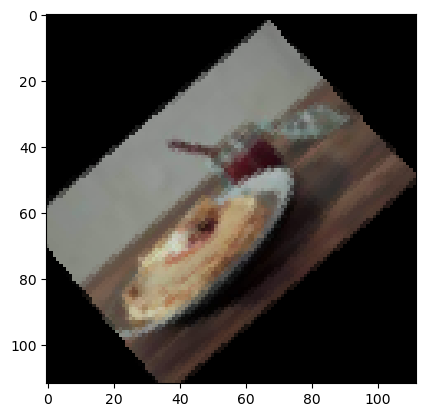

In [5]:
from torchvision import datasets, models, transforms

complete_dataset = np.asarray([[X_train[i], y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(complete_dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    #transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    #transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    #transforms.RandomRotation(degrees=(-45, 45))
]), len_factor=1)

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()


# Define the model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5, padding=2) 
        self.pool1 = nn.MaxPool2d(2, 2) # 56
        self.conv2 = nn.Conv2d(9, 27, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 28
        self.conv3 = nn.Conv2d(27, 81, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 14
        self.fc1 = nn.Linear(81 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = ConvNet()
net.to(device=device)
print(net)

ConvNet(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(27, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15876, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


## Define the training loop - quite similar to example from the exercise

Epoch: 1, loss: 0.514: 100%|██████████| 83/83 [00:20<00:00,  4.10it/s]


------ Epoch 1 ------
avg. Train loss: 0.6369757688189127
Validation loss: 0.6037845636407534 | Validation accuracy: 0.6894444475571314


Epoch: 2, loss: 0.617: 100%|██████████| 83/83 [00:21<00:00,  3.83it/s]


------ Epoch 2 ------
avg. Train loss: 0.46641637295125477
Validation loss: 0.7246518271664778 | Validation accuracy: 0.6075000067551931


Epoch: 3, loss: 0.318: 100%|██████████| 83/83 [00:21<00:00,  3.89it/s]


------ Epoch 3 ------
avg. Train loss: 0.37597185516931925
Validation loss: 0.6371358955899874 | Validation accuracy: 0.6697222292423248


Epoch: 4, loss: 0.352: 100%|██████████| 83/83 [00:21<00:00,  3.89it/s]


------ Epoch 4 ------
avg. Train loss: 0.32431250577231485
Validation loss: 0.36895738045374554 | Validation accuracy: 0.8330555483698845


Epoch: 5, loss: 0.158: 100%|██████████| 83/83 [00:21<00:00,  3.81it/s]


------ Epoch 5 ------
avg. Train loss: 0.2734709538250084
Validation loss: 0.38750961422920227 | Validation accuracy: 0.8383333310484886


Epoch: 6, loss: 0.189: 100%|██████████| 83/83 [00:21<00:00,  3.80it/s] 


------ Epoch 6 ------
avg. Train loss: 0.20650135407067208
Validation loss: 0.38162998979290325 | Validation accuracy: 0.8538888866702715


Epoch: 7, loss: 0.17: 100%|██████████| 83/83 [00:21<00:00,  3.90it/s]  


------ Epoch 7 ------
avg. Train loss: 0.1570354074868093
Validation loss: 0.3757787502060334 | Validation accuracy: 0.8530555541316668


Epoch: 8, loss: 0.0989: 100%|██████████| 83/83 [00:21<00:00,  3.94it/s]


------ Epoch 8 ------
avg. Train loss: 0.14661194532212005
Validation loss: 0.32427563207844895 | Validation accuracy: 0.8747222125530243


Epoch: 9, loss: 0.0959: 100%|██████████| 83/83 [00:21<00:00,  3.86it/s]


------ Epoch 9 ------
avg. Train loss: 0.10701015928244016
Validation loss: 0.371215791751941 | Validation accuracy: 0.8611111069718996


Epoch: 10, loss: 0.0463: 100%|██████████| 83/83 [00:21<00:00,  3.86it/s]


------ Epoch 10 ------
avg. Train loss: 0.14641914895948877
Validation loss: 0.3873879996438821 | Validation accuracy: 0.8777777800957361
Finished Training


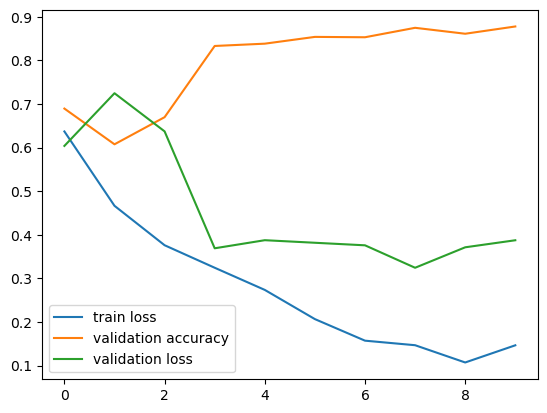

In [8]:

from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def train_model(model, optimizer, criterion=nn.CrossEntropyLoss(), epoch_count=10, batch_size=50):
    torch.manual_seed(42)
    best_acc = 0.0
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracys = []
    running_loss = []

    for epoch in range(epoch_count):  
        
        #execute 1 training iteration over dataset 
        model.train(True)
        train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
        for i, data in enumerate(train_progress, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # print statistics
            running_loss.append(loss.item())
            train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
        
        # stop backpropagation of losses for validationset
        model.train(False)
        
        # calculate validation loss and accur
        print(f"------ Epoch {epoch+1} ------")
    
        val_loss = 0
        val_accuracy = 0
        for i, data in enumerate(valid_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
        val_loss = val_loss / len(valid_dataloader)
        val_accuracy = val_accuracy / len(valid_dataloader)
        
        val_accuracys.append(val_accuracy)
        val_losses.append(val_loss)
        train_losses.append(sum(running_loss)/(len(running_loss)))
        
        if  val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"avg. Train loss: {sum(running_loss)/(len(train_dataloader))}")
        print(f"Validation loss: {val_loss} | Validation accuracy: {val_accuracy}")
        running_loss = []

    print('Finished Training')
    plt.plot(train_losses, label='train loss')
    plt.plot(val_accuracys, label='validation accuracy')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    
    model.load_state_dict(best_model_wts)
    
    return model

train_model(net, optim.Adam(net.parameters(), lr=0.001), epoch_count=10);

### Plot confusion matrix, test accuracy and loss

accuracy: 0.9180327868852459
loss: 0.5444667188298231


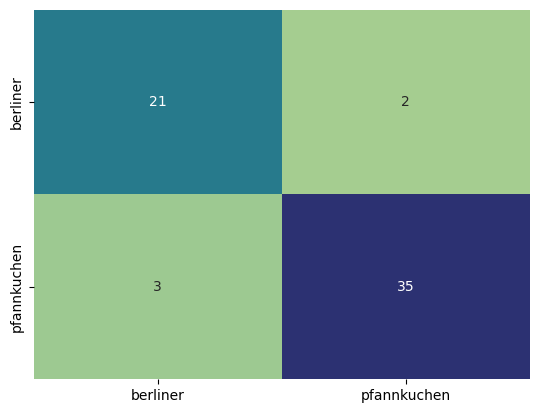

In [9]:
from torchmetrics.classification import MulticlassConfusionMatrix
import seaborn as sns

def test_model(model, valid_dataloader, criterion=nn.CrossEntropyLoss()):
    model.train(False)
    val_loss = 0
    val_accuracy = 0
    targets = []
    preds = []
    input_imgs = []
    count_berliner = 0

    #valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        preds.append(outputs.argmax(dim=1))
        targets.append(labels[0]) # batchsize = 1
        if labels[0] == 1:
            count_berliner += 1
        input_imgs.append(inputs[0]) # batchsize = 1
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
    val_loss = val_loss / len(valid_dataloader)
    val_accuracy = val_accuracy / len(valid_dataloader)

    print("accuracy: {}".format(val_accuracy))
    print("loss: {}".format(val_loss))
    model.train(True)
    
    return targets,preds, input_imgs

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=0)
targets, preds, imgs = test_model(net, test_dataloader)

#plot confusion matrix
cm = MulticlassConfusionMatrix(num_classes=2)
cm.update(torch.tensor(preds), torch.tensor(targets))
sns.heatmap(cm.compute(), annot=True, fmt='d', cmap='crest', cbar=False, xticklabels=['berliner', 'pfannkuchen'], yticklabels=['berliner', 'pfannkuchen']);

target: 0 | pred: tensor([1])


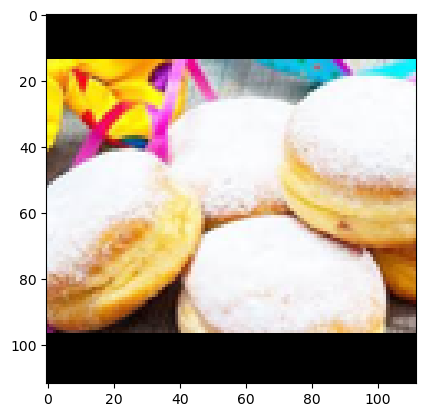

target: 0 | pred: tensor([1])


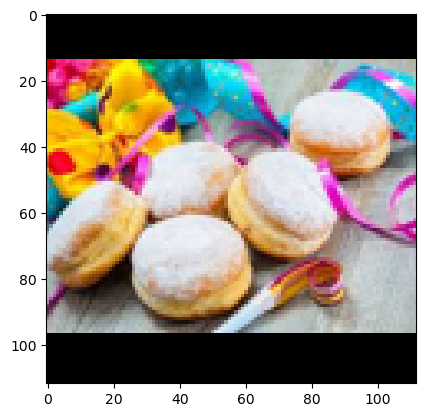

target: 1 | pred: tensor([0])


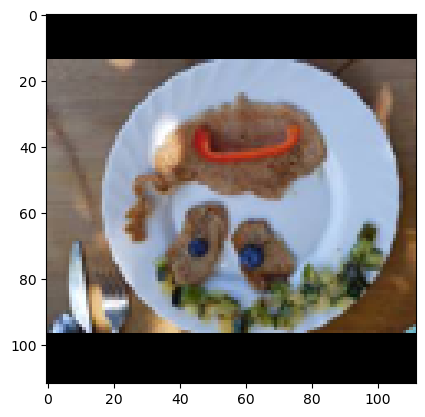

target: 1 | pred: tensor([0])


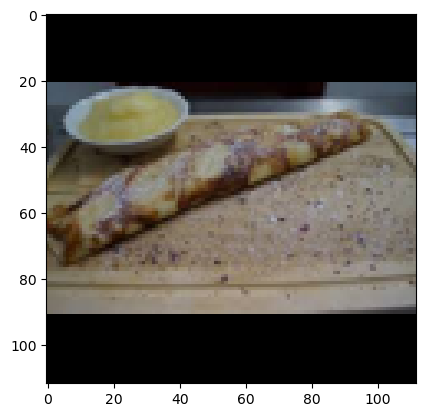

target: 1 | pred: tensor([0])


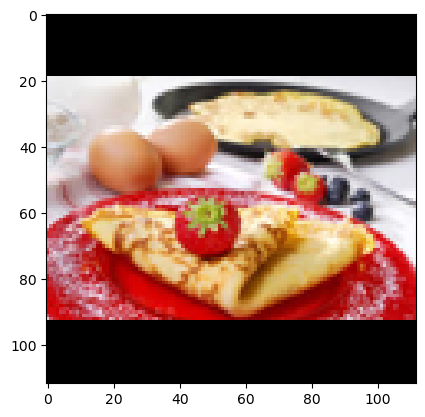

In [10]:
# examine the wrong predictions
wrong_preds = []
for i in range(len(targets)):
    if targets[i] != preds[i]:
        wrong_preds.append(i)

counter = 0
for i in wrong_preds:
    print("target: {} | pred: {}".format(targets[i], preds[i]))
    plt.imshow(imgs[i].permute(1,2,0))
    plt.show()
    counter +=1
    if counter >= 20:
        break

Schwierig genau zu sagen was das konkrete Probleme des Modells mit diesen Bildern / Eingaben ist. Es ist davon auszugehen, dass das Feature anhand wessen klassfiziert wird nicht genug vorhanden ist. Die Lösung hierfür wäre wahrscheinlich ein größerer Datensatz